# cartpole

In [1]:
import collections
import random
import torch
import torch.optim         as optim
import torch.nn            as nn
import torch.nn.functional as F

import gym
from gym import wrappers

import torchinfo

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import animation, rc

In [2]:
DEVICE = "cpu"

In [3]:
class Model(nn.Module):
    def __init__(self, dim_estados, dim_acoes, hparam_rede):
        super(Model, self).__init__()
        
        self.hparam_rede = dict()
        
        self.dim_estados = dim_estados
        self.dim_acoes = dim_acoes
        self.hparam_rede = hparam_rede
        
        self.constroi_modelo()
    
        
    def constroi_modelo(self):
        self.input = nn.Linear( self.dim_estados, self.hparam_rede['hidden_layers'][0] )
        self.hidden = nn.ModuleList()
        for i in range(len(self.hparam_rede['hidden_layers'])-1):
            self.hidden.append( nn.Linear(self.hparam_rede['hidden_layers'][i], self.hparam_rede['hidden_layers'][i+1]) )
        self.output = nn.Linear( self.hparam_rede['hidden_layers'][-1], self.dim_acoes )
    
    
    def forward(self, estado):
        x = estado
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, dtype=torch.float32)
            x = x.unsqueeze(0)
        
        x = self.hparam_rede['func_ativacao']( self.input(x) )
        for h in self.hidden:
            x = self.hparam_rede['func_ativacao']( h(x) )
        x = self.output(x)
        
        return x

In [4]:
class Agent(object):
    def __init__(self, hparams_ambiente, hparams_model, hparams_reforco):
        self.dim_estados = hparams_ambiente['estados']
        self.dim_acoes = hparams_ambiente['acoes']

        self.hparams_model = dict()
        self.hparams_reforco = dict()
        self.memoria = collections.deque()

        self.hparams_model['hidden_layers'] = hparams_model['hidden_layers']
        self.hparams_model['func_ativacao'] = hparams_model['func_ativacao']
        self.modelo = Model(self.dim_estados, self.dim_acoes, self.hparams_model)
        self.hparams_model['func_opt'] = hparams_model['func_opt'](self.modelo.parameters(), lr=0.001)
        self.hparams_model['func_loss'] = hparams_model['func_loss']
     
        self.hparams_reforco['gamma'] = 0.99
        
        
    def act(self, estado, epsilon=0.0):
        x = torch.from_numpy(estado).float().unsqueeze(0).to(DEVICE)
        
        with torch.no_grad():
            acoes = self.modelo(x)
        
        if random.random() > epsilon:
            return np.argmax(acoes.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.dim_acoes))

    
    def remember(self, estado, acao, reward, proximo_estado, done):
        self.memoria.append( (estado, acao, reward, proximo_estado, done) )
    
        
    def learn(self):
        estados, acoes, rewards, prx_estados, dones = list(map(list, zip(*self.memoria)))

        estados = torch.FloatTensor(estados).to(DEVICE)
        prx_estados = torch.FloatTensor(prx_estados).to(DEVICE)
        acoes = torch.LongTensor(acoes).to(DEVICE).view(-1, 1)
        rewards = torch.FloatTensor(rewards).to(DEVICE).view(-1, 1)
        dones = torch.IntTensor(dones).to(DEVICE).view(-1, 1)
        
        max_a_q_sp = self.modelo(prx_estados).detach().max(1)[0].unsqueeze(1) * (1 - dones)
        target_q_s = rewards + max_a_q_sp
        q_sa = self.modelo(estados).gather(1, acoes)
        
        loss = self.hparams_model['func_loss']( target_q_s, q_sa )
        self.hparams_model['func_opt'].zero_grad()
        loss.backward()
        self.hparams_model['func_opt'].step()
        self.memoria = collections.deque()

In [5]:
class Solver():
    def __init__(self, ambiente, hparams_model, hparams_reforco):
        self.env = ambiente
        
        self.hparams_ambiente = dict()
        self.hparams_model = hparams_model
        self.hparams_reforco = hparams_reforco
        
        self.hparams_ambiente['estados'] = self.env.observation_space.shape[0]
        self.hparams_ambiente['acoes'] = self.env.action_space.n
        
        self.agent = Agent(self.hparams_ambiente, self.hparams_model, self.hparams_reforco)
        self.scores = list()
        
    def solve(self, episodios):
        estado = self.env.reset()
        
        for e in range(episodios + 1):
            estado = self.env.reset()
            score = 0
            done = False
            epsilon = max( 1 -  e/episodios, 0.05)

            while not(done):
                acao = self.agent.act(estado, epsilon)                     # observe state -> take action
                prx_estado, reward, done, _ = self.env.step(acao)          # feedback -> new state
                score += reward                                            # recompensa
                self.agent.remember(estado, acao, score, prx_estado, done)
                estado = prx_estado                                        # novo estado
            self.agent.learn()
            self.scores.append(score)

            if (e % 1000 == 0) and (e > 1):
                print( "episodio : {:>6} de {:>6}  |  (media movel, media, mediana, epsilon) = ({:>3}, {:>3}, {:>3}, {:>3})".format(
                    e, episodios, int(np.mean(self.scores[-100:])), int(np.mean(self.scores)), int(np.median(self.scores)), epsilon) )
            
            if int(np.mean(self.scores[-100:])) > 195:
                print("RESOLVIDO!")
                break

In [9]:
def env_savegif(frames, path, fname):
    try:
        plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi=72)
    except:
        plt.figure(figsize=(frames[0].get_size()[1] / 72.0, frames[0].get_size()[0] / 72.0), dpi=72)
    patch = plt.imshow(frames[0])
    plt.axis('off')
    
    def animate(i):
        patch.set_data(frames[i])
    
    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=5)
    anim.save(path + fname, writer='imagemagick', fps=60)

In [6]:
env = gym.make("CartPole-v1")

hparams_model = {
    "hidden_layers" : (64, 64) , 
    "func_ativacao" : F.relu ,
    "func_opt" : optim.RMSprop , 
    "func_loss" : F.mse_loss , 
}

hparams_reforco = {    
}

RL = Solver(gym.make("CartPole-v1"), hparams_model, hparams_reforco)

In [7]:
RL.solve(20000)

episodio :   1000 de  20000  |  (media movel, media, mediana, epsilon) = ( 22,  22,  19, 0.95)
episodio :   2000 de  20000  |  (media movel, media, mediana, epsilon) = ( 22,  22,  19, 0.9)
episodio :   3000 de  20000  |  (media movel, media, mediana, epsilon) = ( 26,  23,  19, 0.85)
episodio :   4000 de  20000  |  (media movel, media, mediana, epsilon) = ( 34,  25,  21, 0.8)
episodio :   5000 de  20000  |  (media movel, media, mediana, epsilon) = ( 38,  27,  22, 0.75)
episodio :   6000 de  20000  |  (media movel, media, mediana, epsilon) = ( 42,  29,  24, 0.7)
episodio :   7000 de  20000  |  (media movel, media, mediana, epsilon) = ( 51,  32,  25, 0.65)
episodio :   8000 de  20000  |  (media movel, media, mediana, epsilon) = ( 68,  36,  28, 0.6)
episodio :   9000 de  20000  |  (media movel, media, mediana, epsilon) = ( 96,  41,  30, 0.55)
episodio :  10000 de  20000  |  (media movel, media, mediana, epsilon) = (138,  48,  33, 0.5)
episodio :  11000 de  20000  |  (media movel, media, me

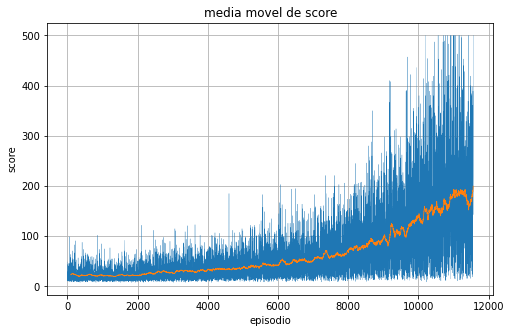

In [8]:
pd.Series(RL.scores).plot(linewidth=0.25)
pd.Series(RL.scores).rolling(100).mean().plot(linewidth=0.75, figsize=(8, 5))

plt.xlabel("episodio")
plt.ylabel("score")
plt.title("media movel de score")
plt.grid()

In [14]:
observation = env.reset()
firstframe = env.render(mode = 'rgb_array')
frames = [firstframe]

for i in range(300):
    action = env.action_space.sample() # action = RL.agent.act(observation)
    
    observation, reward, done, info = env.step(action)
    frame = env.render(mode = 'rgb_array')
    frames.append(frame)
    if done:
        break
env.close()

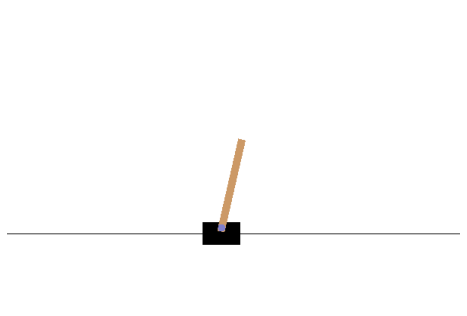

In [15]:
env_savegif(frames, "img/", "random.gif")

In [16]:
observation = env.reset()
firstframe = env.render(mode = 'rgb_array')
frames = [firstframe]

for i in range(300):
    action = RL.agent.act(observation)
    
    observation, reward, done, info = env.step(action)
    frame = env.render(mode = 'rgb_array')
    frames.append(frame)
    if done:
        break
env.close()

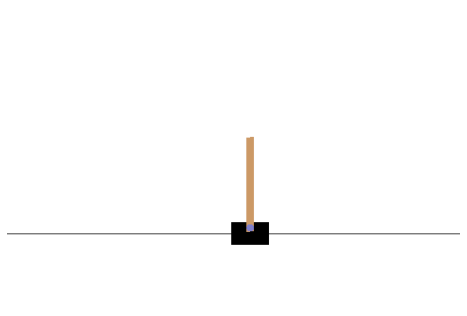

In [17]:
env_savegif(frames, "img/", "treinado.gif")

# mountaincar

In [18]:
class Model(nn.Module):
    def __init__(self, dim_estados, dim_acoes, hparam_rede):
        super(Model, self).__init__()
        
        self.hparam_rede = dict()
        
        self.dim_estados = dim_estados
        self.dim_acoes = dim_acoes
        self.hparam_rede = hparam_rede
        
        self.constroi_modelo()
    
        
    def constroi_modelo(self):
        self.input = nn.Linear( self.dim_estados, self.hparam_rede['hidden_layers'][0] )
        self.hidden = nn.ModuleList()
        for i in range(len(self.hparam_rede['hidden_layers'])-1):
            self.hidden.append(nn.Dropout(0.1))
            self.hidden.append( nn.Linear(self.hparam_rede['hidden_layers'][i], self.hparam_rede['hidden_layers'][i+1]) )
        self.output = nn.Linear( self.hparam_rede['hidden_layers'][-1], self.dim_acoes )
    
    
    def forward(self, estado):
        x = estado
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, dtype=torch.float32)
            x = x.unsqueeze(0)
        
        x = self.hparam_rede['func_ativacao']( self.input(x) )
        for h in self.hidden:
            x = self.hparam_rede['func_ativacao']( h(x) )
        # x = F.softmax(self.output(x), dim=0)
        x = self.output(x)
        
        return x

In [19]:
class Agent(object):
    def __init__(self, hparams_ambiente, hparams_model, hparams_reforco):
        self.dim_estados = hparams_ambiente['estados']
        self.dim_acoes = hparams_ambiente['acoes']

        self.hparams_model = dict()
        self.hparams_reforco = dict()
        self.memoria = collections.deque()

        self.hparams_model['hidden_layers'] = hparams_model['hidden_layers']
        self.hparams_model['func_ativacao'] = hparams_model['func_ativacao']
        self.modelo = Model(self.dim_estados, self.dim_acoes, self.hparams_model)
        self.hparams_model['func_opt'] = hparams_model['func_opt'](self.modelo.parameters(), lr=0.001)
        self.hparams_model['func_loss'] = hparams_model['func_loss']
     
        self.hparams_reforco['gamma'] = 0.99
        
        
    def act(self, estado, epsilon=0.0):
        x = torch.from_numpy(estado).float().unsqueeze(0).to(DEVICE)
        
        with torch.no_grad():
            acoes = self.modelo(x)
        
        if random.random() > epsilon:
            return np.argmax(acoes.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.dim_acoes))

    
    def remember(self, estado, acao, reward, proximo_estado, done):
        self.memoria.append( (estado, acao, reward, proximo_estado, done) )
    
        
    def learn(self):
        estados, acoes, rewards, prx_estados, dones = list(map(list, zip(*self.memoria)))

        estados = torch.FloatTensor(estados).to(DEVICE)
        prx_estados = torch.FloatTensor(prx_estados).to(DEVICE)
        acoes = torch.LongTensor(acoes).to(DEVICE).view(-1, 1)
        rewards = torch.FloatTensor(rewards).to(DEVICE).view(-1, 1)
        dones = torch.IntTensor(dones).to(DEVICE).view(-1, 1)
        
        max_a_q_sp = self.modelo(prx_estados).detach().max(1)[0].unsqueeze(1) * (1 - dones)
        target_q_s = rewards + max_a_q_sp
        q_sa = self.modelo(estados).gather(1, acoes)
        
        loss = self.hparams_model['func_loss']( target_q_s, q_sa )
        self.hparams_model['func_opt'].zero_grad()
        loss.backward()
        self.hparams_model['func_opt'].step()
        self.memoria = collections.deque()

In [20]:
class Solver():
    def __init__(self, ambiente, hparams_model, hparams_reforco):
        self.env = ambiente
        
        self.hparams_ambiente = dict()
        self.hparams_model = hparams_model
        self.hparams_reforco = hparams_reforco
        
        self.hparams_ambiente['estados'] = self.env.observation_space.shape[0]
        self.hparams_ambiente['acoes'] = self.env.action_space.n
        
        self.agent = Agent(self.hparams_ambiente, self.hparams_model, self.hparams_reforco)
        self.scores = list()
        self.sucesso = 0
        self.epsilon = 0.333
        self.max_score = -np.inf
        
    def solve(self, episodios):
        estado = self.env.reset()
        
        for e in range(episodios + 1):
            estado = self.env.reset()
            score = 0
            done = False
            # epsilon = max( 1 -  e/episodios, 0.05)

            for _ in range(self.hparams_reforco["MAX"]):
                acao = self.agent.act(estado, self.epsilon)                # observe state -> take action
                prx_estado, reward, done, _ = self.env.step(acao)          # feedback -> new state
                
                #score += reward                                           # recompensa
                score = prx_estado[0] + 0.5
                if prx_estado[0] >= 0.5:
                    score += 1
                
                if score > self.max_score:
                    self.max_score = score
                
                self.agent.remember(estado, acao, score, prx_estado, done)
                if done:
                    if prx_estado[0] >= 0.5:
                        self.epsilon *= .9
                        self.sucesso += 1
                        print(rf"RESOLVIDO! (episodio {e}, {self.sucesso} sucessos, score {score})")
                        break
                else:
                    estado = prx_estado                                        # novo estado
            self.agent.learn()
            self.scores.append(score)

            if (e % 100 == 0) and (e > 1):
                print( "episodio : {:>6} de {:>6}  |  (score, media movel, media, mediana, epsilon) = ({:>3}, {:>3}, {:>3}, {:>3}, {:>3}) | max score : {:>3}".format(
                    e, episodios, round(score, 3), round(np.mean(self.scores[-100:]),3), round(np.mean(self.scores), 3), round(np.median(self.scores), 3), round(self.epsilon, 3), round(self.max_score, 3)) )

In [21]:
hparams_model = {
    "hidden_layers" : (5, 50, 5) , 
    "func_ativacao" : F.relu ,
    "func_opt" : optim.RMSprop , 
    "func_loss" : F.mse_loss , 
}

hparams_reforco = {    
    "MAX" : 555 ,
}

RL = Solver(gym.make("MountainCar-v0"), hparams_model, hparams_reforco)

In [22]:
RL.agent.modelo

Model(
  (input): Linear(in_features=2, out_features=5, bias=True)
  (hidden): ModuleList(
    (0): Dropout(p=0.1, inplace=False)
    (1): Linear(in_features=5, out_features=50, bias=True)
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=50, out_features=5, bias=True)
  )
  (output): Linear(in_features=5, out_features=3, bias=True)
)

In [23]:
torchinfo.summary(RL.agent.modelo)

Layer (type:depth-idx)                   Param #
Model                                    --
├─Linear: 1-1                            15
├─ModuleList: 1-2                        --
│    └─Dropout: 2-1                      --
│    └─Linear: 2-2                       300
│    └─Dropout: 2-3                      --
│    └─Linear: 2-4                       255
├─Linear: 1-3                            18
Total params: 588
Trainable params: 588
Non-trainable params: 0

In [24]:
RL.solve(1000)

episodio :    100 de   1000  |  (score, media movel, media, mediana, epsilon) = (-0.171, -0.027, -0.024, -0.035, 0.333) | max score : 0.644
episodio :    200 de   1000  |  (score, media movel, media, mediana, epsilon) = (0.035, 0.01, -0.007, -0.015, 0.333) | max score : 0.644
episodio :    300 de   1000  |  (score, media movel, media, mediana, epsilon) = (0.197, 0.075, 0.02, 0.031, 0.333) | max score : 0.65
episodio :    400 de   1000  |  (score, media movel, media, mediana, epsilon) = (0.232, 0.041, 0.025, 0.037, 0.333) | max score : 0.65
episodio :    500 de   1000  |  (score, media movel, media, mediana, epsilon) = (0.266, 0.054, 0.031, 0.038, 0.333) | max score : 0.703
episodio :    600 de   1000  |  (score, media movel, media, mediana, epsilon) = (-0.193, 0.024, 0.03, 0.039, 0.333) | max score : 0.703
RESOLVIDO! (episodio 679, 1 sucessos, score 2.012762665748596)
episodio :    700 de   1000  |  (score, media movel, media, mediana, epsilon) = (-0.065, 0.028, 0.03, 0.037, 0.3) | max

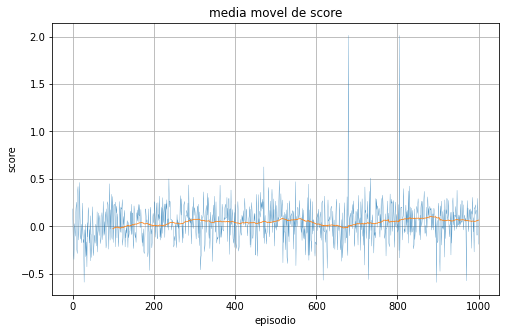

In [25]:
pd.Series(RL.scores).plot(linewidth=0.25)
pd.Series(RL.scores).rolling(100).mean().plot(linewidth=0.75, figsize=(8, 5))

plt.xlabel("episodio")
plt.ylabel("score")
plt.title("media movel de score")
plt.grid()

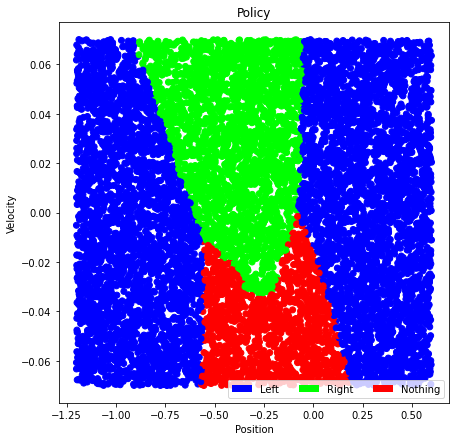

In [516]:
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
from torch.autograd import Variable

X = np.random.uniform(-1.2, 0.6, 10000)
Y = np.random.uniform(-0.07, 0.07, 10000)
Z = []

for i in range(len(X)):
    z = RL.agent.act(np.array([X[i], Y[i]])).item()
    Z.append(z)
Z = pd.Series(Z)

colors = {0:'blue',1:'lime',2:'red'}
colors = Z.apply(lambda x:colors[x])
labels = ['esquerda', 'direita', 'nada']

fig = plt.figure(3, figsize=[7,7])
ax = fig.gca()
plt.set_cmap('brg')
surf = ax.scatter(X,Y, c=Z)

ax.set_xlabel('posicao')
ax.set_ylabel('velocidade')
ax.set_title('politica')

recs = []
for i in range(0,3):
     recs.append(mpatches.Rectangle((0,0),1,1,fc=sorted(colors.unique())[i]))
plt.legend(recs,labels,loc=4,ncol=3)
plt.show()

In [26]:
env = gym.make("MountainCar-v0")
observation = env.reset()
firstframe = env.render(mode = 'rgb_array')
frames = [firstframe]

for i in range(5000):
    action = RL.agent.act(observation)
    observation, reward, done, info = env.step(action)
    frame = env.render(mode = 'rgb_array')
    frames.append(frame)
    if done:
        break
env.close()

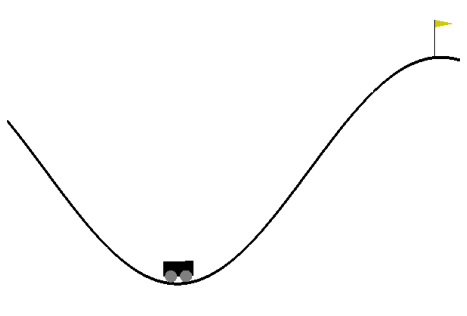

In [27]:
env_savegif(frames, "img/", "mountaincar_treinado.gif")

.